## Use Case 5: Content Recommendation Optimization


The goal of this use case is to optimize content recommendations by understanding which types of movies are similar in terms of audience appeal.

***Import libraries & load Dataset***

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Load dataset
df = spark.table("default.tmdb_5000_movies")
# Select relevant features for clustering
df = df.select("title", "budget", "revenue", "popularity", "vote_average", "vote_count")
df.show(5)

+--------------------+---------+----------+----------+------------+----------+
|               title|   budget|   revenue|popularity|vote_average|vote_count|
+--------------------+---------+----------+----------+------------+----------+
|              Avatar|237000000|2787965087|150.437577|         7.2|     11800|
|Pirates of the Ca...|300000000| 961000000|139.082615|         6.9|      4500|
|             Spectre|245000000| 880674609|107.376788|         6.3|      4466|
|The Dark Knight R...|250000000|1084939099| 112.31295|         7.6|      9106|
|         John Carter|260000000| 284139100| 43.926995|         6.1|      2124|
+--------------------+---------+----------+----------+------------+----------+
only showing top 5 rows


***Feature Preparation***

In [0]:
# Fill missing values
df = df.na.fill(0)

# Assemble features into a single column
assembler = VectorAssembler(
    inputCols=["budget", "revenue", "popularity", "vote_average", "vote_count"],
    outputCol="features"
)
feature_df = assembler.transform(df)

# Scale features for better clustering
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scaled_df = scaler.fit(feature_df).transform(feature_df)

scaled_df.select("scaled_features").show(3)


+--------------------+
|     scaled_features|
+--------------------+
|[5.82078734150074...|
|[7.36808524240600...|
|[6.01726961463157...|
+--------------------+
only showing top 3 rows


***Apply K-Means Clustering***

In [0]:
from pyspark.ml.clustering import KMeans

# Initialize K-Means model
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=42)
kmeans_model = kmeans.fit(scaled_df)

# Assign cluster labels
clustered_df = kmeans_model.transform(scaled_df)

# View sample cluster assignments
clustered_df.select("title", "popularity", "vote_average", "vote_count", "prediction").show(10)


+--------------------+----------+------------+----------+----------+
|               title|popularity|vote_average|vote_count|prediction|
+--------------------+----------+------------+----------+----------+
|              Avatar|150.437577|         7.2|     11800|         1|
|Pirates of the Ca...|139.082615|         6.9|      4500|         1|
|             Spectre|107.376788|         6.3|      4466|         3|
|The Dark Knight R...| 112.31295|         7.6|      9106|         1|
|         John Carter| 43.926995|         6.1|      2124|         3|
|        Spider-Man 3|115.699814|         5.9|      3576|         3|
|             Tangled| 48.681969|         7.4|      3330|         3|
|Avengers: Age of ...|134.279229|         7.3|      6767|         1|
|Harry Potter and ...| 98.885637|         7.4|      5293|         3|
|Batman v Superman...|155.790452|         5.7|      7004|         1|
+--------------------+----------+------------+----------+----------+
only showing top 10 rows


***Analyze Cluster Centers***

In [0]:
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"Cluster {i} center:\n{center}\n")


Cluster 0 center:
[0.27818645 0.10903705 0.30444276 3.34121878 0.15206618]

Cluster 1 center:
[4.55035083 6.54352229 7.12613025 4.13638484 6.27548917]

Cluster 2 center:
[1.30393981 0.88490871 1.15529559 3.65603042 0.98157015]

Cluster 3 center:
[3.06105684 3.04689721 2.38122094 4.02073104 3.08345973]



Each number represents the scaled average value of features (budget, revenue, popularity, vote_average, vote_count) for that cluster.

Cluster 1 shows the highest overall feature values, meaning it contains blockbusters with high budgets, revenues, and strong audience engagement.

Cluster 0 and Cluster 2 represent low-budget, low-engagement movies, possibly niche or indie films.

Cluster 3 has moderate values — indicating movies with decent popularity and ratings but not massive commercial hits.

***Visualize Clusters***

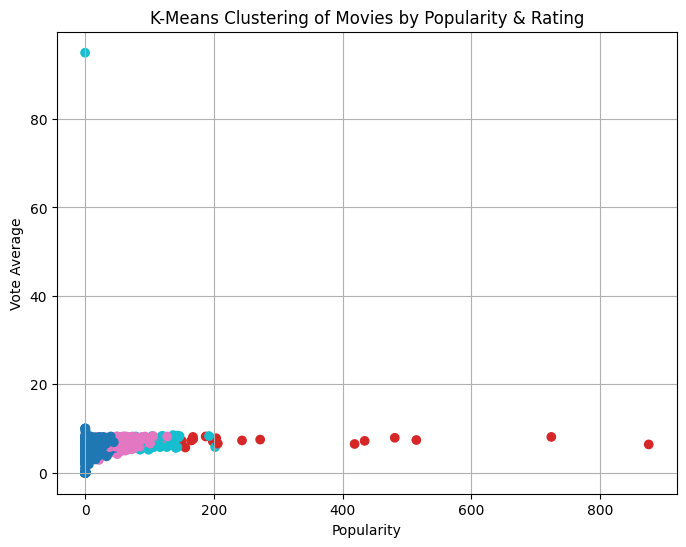

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

cluster_pd = clustered_df.select("popularity", "vote_average", "prediction").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(cluster_pd["popularity"], cluster_pd["vote_average"], c=cluster_pd["prediction"], cmap="tab10")
plt.title("K-Means Clustering of Movies by Popularity & Rating")
plt.xlabel("Popularity")
plt.ylabel("Vote Average")
plt.grid(True)
plt.show()


***SQL Based summary***

In [0]:
# Create temporary SQL view
clustered_df.createOrReplaceTempView("movie_clusters")

# Run SQL summary
sql_result = spark.sql("""
    SELECT prediction AS cluster,
           ROUND(AVG(popularity), 2) AS avg_popularity,
           ROUND(AVG(vote_average), 2) AS avg_rating,
           ROUND(AVG(vote_count), 2) AS avg_votes,
           COUNT(*) AS movie_count
    FROM movie_clusters
    GROUP BY prediction
    ORDER BY cluster
""")

display(sql_result)


cluster,avg_popularity,avg_rating,avg_votes,movie_count
0,9.69,5.89,187.7,3319
1,226.71,7.29,7746.15,33
2,36.75,6.45,1211.6,1194
3,75.75,7.09,3806.07,260


***Visualization of Cluster Summary***

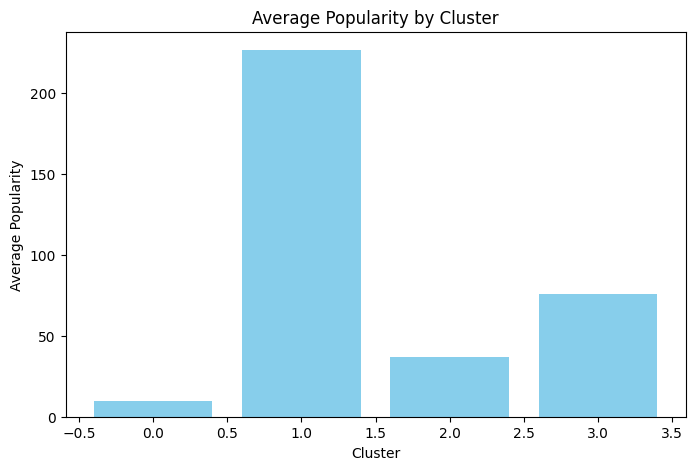

In [0]:
# Convert to Pandas for plotting
pdf = sql_result.toPandas()

plt.figure(figsize=(8,5))
plt.bar(pdf["cluster"], pdf["avg_popularity"], color='skyblue')
plt.title("Average Popularity by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Popularity")
plt.show()



Cluster 1 has the highest average popularity, meaning it consists of the most successful and widely recognized movies (blockbusters or franchise hits).

Cluster 3 follows with moderately popular, well-received movies.

Cluster 0 and Cluster 2 have low average popularity, representing niche or low-performing films.

This indicates a clear popularity gradient — useful for recommendation and marketing segmentation.

***Code Snippet for Recommendation Demo***

In [0]:
from pyspark.sql.functions import col

# Rename 'prediction' column (created by K-Means) to 'cluster'
clustered_df = clustered_df.withColumnRenamed("prediction", "cluster")

# Example: Recommend similar movies to 'Interstellar'
target_movie = 'Interstellar'

# Get cluster ID for target movie
target_cluster = clustered_df.filter(col("title") == target_movie).select("cluster").collect()[0][0]

# Fetch similar movies from same cluster (excluding target movie)
recommended_movies = clustered_df.filter((col("cluster") == target_cluster) & (col("title") != target_movie)) \
                                 .select("title", "popularity", "vote_average") \
                                 .limit(5)

# Display recommendations
display(recommended_movies)


title,popularity,vote_average
Avatar,150.437577,7.2
Pirates of the Caribbean: At World's End,139.082615,6.9
The Dark Knight Rises,112.31295,7.6
Avengers: Age of Ultron,134.279229,7.3
Batman v Superman: Dawn of Justice,155.790452,5.7


**The K-Means clustering model successfully categorized movies into four distinct groups based on popularity, rating, revenue, and engagement.
Cluster 1 contained major blockbusters with the highest popularity, while Clusters 0 and 2 represented niche or low-engagement films.
The analysis reveals strong segmentation in the entertainment industry, enabling better content recommendation, marketing strategy, and audience targeting decisions.**

***Each cluster represents a “content group”***

***🎬 Cluster 1 → Blockbusters***

***🎥 Cluster 3 → Critically acclaimed & fan-favorite***

***🎞 Cluster 0 → Low-budget niche***

📽 ***Cluster 2 → Moderate performing films***